In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
from torch.nn import Parameter

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats

In [3]:
meshes=['01','02','03','04','05','06','07','08','09','10']

Ys=[]
Xs=[]

for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/X.txt",index_col=None,delim_whitespace=True,header=None).values
    outputData = pd.read_csv("/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case"+val+"/Y.txt",index_col=None,delim_whitespace=True,header=None).values

    

    Xs.append(torch.tensor(inputData[0:200]))
    Ys.append(torch.tensor(outputData[0:200]))

In [4]:
train_input=[]
test_input = []
train_output=[]
test_output = []

for i in range(len(meshes)):

    X=Xs[i]
    y=Ys[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input.append(X_train)
    test_input.append(X_test)
    train_output.append(y_train)
    test_output.append(y_test)
    
    

# GP-LVM Tests

In [5]:
A_TAT_all = train_output[0][:,[0]]

for i in range(len(train_output)-1):
    A_TAT_all=torch.cat((A_TAT_all,train_output[i+1][:,[0]]),axis=1)
V_TAT_all = train_output[0][:,[1]]
for i in range(len(train_output)-1):
    V_TAT_all=torch.cat((V_TAT_all,train_output[i+1][:,[1]]),axis=1)

In [6]:
y=torch.cat([A_TAT_all,V_TAT_all])

In [7]:
y

tensor([[7.7974, 4.6262, 5.5459,  ..., 5.5082, 3.5244, 5.0166],
        [4.7434, 4.3126, 7.3091,  ..., 3.9670, 4.1047, 5.2281],
        [5.6131, 4.4617, 3.7402,  ..., 3.7322, 4.9097, 4.3379],
        ...,
        [4.3326, 2.9332, 4.7540,  ..., 2.8748, 5.1960, 7.0946],
        [4.1194, 2.2553, 2.0868,  ..., 3.5631, 5.9122, 5.3571],
        [3.5823, 4.6100, 4.8115,  ..., 4.1967, 7.7667, 9.0501]],
       dtype=torch.float64)

In [8]:
feats=15

In [9]:
# we setup the mean of our prior over X
X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2

In [10]:
X = Parameter(X_prior_mean.clone())
kernel = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

In [11]:
# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 10)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

In [12]:
# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
gplvm.autoguide("X", dist.Normal)

In [13]:
gplvm.X_loc

Parameter containing:
tensor([[ 6.5968e-02,  9.5978e-02,  6.3325e-02, -1.3222e-01,  2.0720e-02,
         -7.1039e-02,  2.0578e-02, -1.7767e-02, -1.9559e-02, -1.1134e-02,
         -5.2843e-02,  1.2911e-01, -1.5939e-01, -3.6164e-04,  9.1560e-02],
        [-2.0747e-02,  1.1194e-02,  9.6466e-02,  5.1226e-02, -1.2444e-01,
          1.3526e-01,  8.5018e-02, -1.0334e-01, -1.5890e-02, -1.7253e-01,
          4.9844e-02,  5.7940e-02,  1.3473e-01, -2.1551e-01, -2.5623e-01],
        [ 1.0482e-01, -4.5242e-02, -5.7435e-02,  2.1929e-01,  1.1706e-01,
         -1.0697e-01, -2.7845e-02,  2.1533e-01,  6.3900e-03, -4.2033e-02,
          1.9296e-02, -6.5345e-02,  2.1214e-03, -4.9372e-02, -3.9203e-02],
        [ 1.5338e-02,  1.6270e-01,  1.1918e-01,  4.8888e-02,  1.5710e-01,
          5.5285e-02, -3.1903e-01, -8.0075e-02, -6.1941e-02, -8.3849e-02,
          3.3359e-02,  3.7925e-02,  2.2616e-01, -1.2858e-01, -1.1271e-01],
        [-7.6124e-02,  2.1564e-01, -2.3566e-01,  1.6121e-01, -1.4642e-01,
         -2.

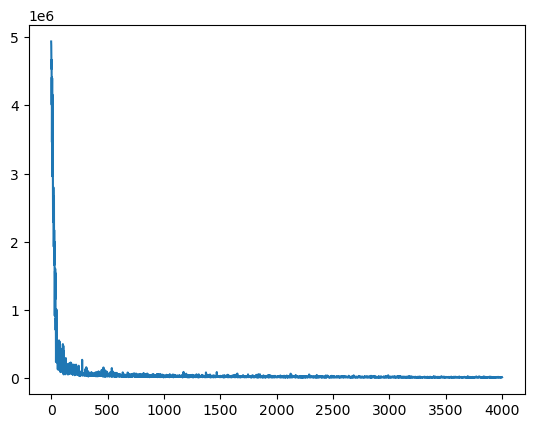

In [14]:
# note that training is expected to take a minute or so
losses = gp.util.train(gplvm, num_steps=4000)

# let's plot the loss curve after 4000 steps of training
plt.plot(losses)
plt.show()

In [15]:
gplvm.X_loc

Parameter containing:
tensor([[-0.3951,  0.2686,  0.3931, -0.2160, -0.1469,  0.4159,  0.6423, -0.0543,
          0.1416,  0.0085, -0.3023,  0.2082, -0.3799,  0.6116,  0.3192],
        [ 0.2141,  0.2647, -0.4802,  0.0479, -0.0657, -0.0112, -0.0553, -0.9635,
         -0.0486,  0.2389,  0.0438, -0.3010,  0.2217,  0.4247, -0.3283],
        [ 0.2884,  0.1240,  0.2804,  0.0601, -0.5575, -0.4203, -0.8652, -0.3007,
         -0.1276,  0.1542, -0.0725, -0.0459,  0.3177,  0.0683, -0.0883],
        [ 0.1395, -0.2413,  0.1982,  0.0703,  0.2781, -0.4758,  0.0619,  0.2306,
          0.0815,  0.1105,  0.0816,  0.3061,  0.4430, -0.2259, -0.0371],
        [-0.0315, -0.3287, -0.0254,  0.2956,  0.1110, -0.3381,  0.2409,  0.1846,
          0.2235,  0.1071, -0.1040,  0.6278,  0.2214, -0.3114,  0.3344],
        [ 0.2426,  0.4714,  0.2070, -0.3821,  0.2878,  0.8109,  0.2704, -0.1923,
         -0.3173, -0.4292, -0.0210, -0.1689, -0.5964, -0.6238, -0.3766],
        [-0.2778,  0.1535,  0.2256, -0.1144,  0.4551, 

In [16]:
X.shape

torch.Size([10, 15])

0
1
2
3
4
5
6
7
8
9


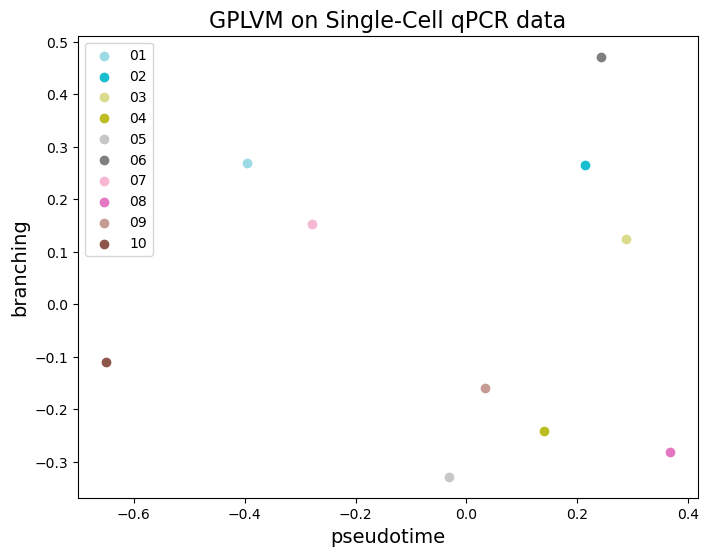

In [17]:
plt.figure(figsize=(8, 6))
colors = plt.get_cmap("tab20").colors[::-1]
labels = meshes

X = gplvm.X_loc
Xs2 = torch.split(X,1)
for i, label in enumerate(labels):
    print(i)
    X_i = Xs2[i].detach().numpy()
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("GPLVM on Single-Cell qPCR data", fontsize=16)
plt.show()

In [18]:
X.shape

torch.Size([10, 15])

In [19]:
all_input_gp=[]
test_input_gp=[]
test_output_gp=[]
train_input_gp=[]
train_output_gp=[] 
for i in range(len(meshes)):
    val=meshes[i]
    
    inputData = Xs[i]
    modeweights = torch.tile(X[i,:], (inputData.shape[0],1))
    input_modes = torch.cat((inputData,modeweights),axis=1)
    all_input_gp.append(torch.tensor(input_modes))
    
for i in range(len(meshes)):

    X=all_input_gp[i]
    y=Ys[i]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed+i
    )
    train_input_gp.append(X_train)
    test_input_gp.append(X_test)
    train_output_gp.append(y_train)
    test_output_gp.append(y_test)


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_72587/3718578479.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_input_gp.append(torch.tensor(input_modes))


In [20]:
reps = 5
train_p = np.linspace(100,800,8)
train_p=np.array([10,15,20,25,30,35,40,45,50])*17

R2_test_gp = torch.zeros(len(train_p),reps,len(meshes),7)
R2_leftout_gp= torch.zeros(len(train_p),reps,len(meshes),7)
for k in range(len(train_p)):
    for i in range(len(meshes)):
        for j in range(reps):

            X=torch.cat(train_input_gp[0:i]+train_input_gp[i+1:])
            y=torch.cat(train_output_gp[:i]+train_output_gp[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                train_size=int(train_p[k]),
                random_state=j
            )
            X_test= torch.cat(test_input_gp[0:i]+test_input_gp[i+1:])
            y_test=torch.cat(test_output_gp[:i]+test_output_gp[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test_gp[k,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_gp[i],test_output_gp[i],1000) 
            R2_leftout_gp[k,j,i,:] = meanR
            print(R2_test_gp[k,j,i,:])
            print(R2_leftout_gp[k,j,i,:])

0
1
2
3
4
5
6


/Users/pmzcwl/Documents/GitHub/Calibration/GPyEm/GPE_ensemble.py:230: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T


tensor([0.7913, 0.8333, 0.7995, 0.8514, 0.9066, 0.5691, 0.9673])
tensor([-1.8442e+01, -9.5880e+00, -1.5392e+02,  1.3261e-01, -6.6430e+01,
        -1.0578e+02, -9.2859e+00])
0
1
2
3
4
5
6
tensor([0.7743, 0.8100, 0.7670, 0.8162, 0.8969, 0.5886, 0.9711])
tensor([ -14.4570, -144.5928,  -92.0456,  -25.5674,  -56.0851,  -52.5706,
          -3.5574])
0
1
2
3
4
5
6
tensor([0.8110, 0.8671, 0.8059, 0.8342, 0.9012, 0.6445, 0.9778])
tensor([  -9.6888,  -51.7419, -205.5684,   -0.5692,   -1.7572,  -23.4448,
         -23.3370])
0
1
2
3
4
5
6
tensor([0.7761, 0.8642, 0.7592, 0.8137, 0.9034, 0.5184, 0.9719])
tensor([  -7.8992,   -8.9039,  -48.2613,  -19.8127,   -6.1232,   -2.6636,
        -353.5485])
0
1
2
3
4
5
6
tensor([0.8108, 0.8579, 0.6721, 0.8553, 0.9139, 0.5426, 0.9719])
tensor([-26.5577, -85.8402, -24.8392, -43.4310,  -4.5799,  -3.7115, -68.5084])
0
1
2
3
4
5
6
tensor([0.7942, 0.7673, 0.7444, 0.8203, 0.9086, 0.5317, 0.9630])
tensor([  0.1257,  -3.3573, -19.8572, -19.5803,  -2.2912,  -2.5168, -74

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.

In [ ]:
i

In [ ]:
meanR

In [ ]:
800/17

In [ ]:
R2_test.mean(axis=[1,2])[:8].detach()

In [ ]:
R2_test_gp.mean(axis=[1,2])[:8].detach()

In [ ]:
R2_leftout.mean(axis=[1,2])[:8].detach()

In [ ]:
R2_leftout_gp.mean(axis=[1,2])[:8]

In [ ]:
fontS=12

In [ ]:
fig, ax = plt.subplots()

plt.errorbar(train_p[:8],R2_test_gp.mean(axis=[1,2])[:8,0].detach().numpy(),fmt='o',yerr=R2_test_gp.std(axis=[1,2])[:8,0].detach().numpy())
plt.errorbar(train_p[:8],R2_test_gp.mean(axis=[1,2])[:8,1].detach().numpy(),fmt='o',yerr=R2_test_gp.std(axis=[1,2])[:8,1].detach().numpy())

plt.legend(('A_TAT','V_TAT','A_TAT GP','V_TAT GP'),fontsize=fontS)
plt.xlabel('Training Points',fontsize=fontS)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTLatentNLeftin.pdf' )

In [59]:
R2_test.mean(axis=[1,2])[:7,]

tensor([[0.9858, 0.9755],
        [0.9919, 0.9849],
        [0.9949, 0.9896],
        [0.9963, 0.9921],
        [0.1994, 0.1987],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])

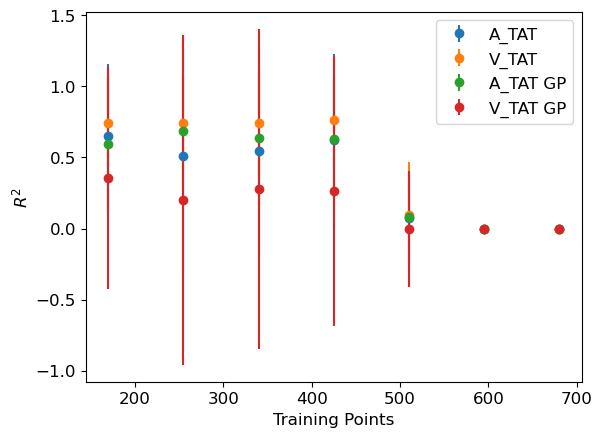

In [60]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(train_p[:7],R2_leftout.mean(axis=[1,2])[:7,0].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:7,0].detach().numpy())
plt.errorbar(train_p[:7],R2_leftout.mean(axis=[1,2])[:7,1].detach().numpy(),fmt='o',yerr=R2_leftout.std(axis=[1,2])[:7,1].detach().numpy())

plt.errorbar(train_p[:7],R2_leftout_gp.mean(axis=[1,2])[:7,0].detach().numpy(),fmt='o',yerr=R2_leftout_gp.std(axis=[1,2])[:7,0].detach().numpy())
plt.errorbar(train_p[:7],R2_leftout_gp.mean(axis=[1,2])[:7,1].detach().numpy(),fmt='o',yerr=R2_leftout_gp.std(axis=[1,2])[:7,1].detach().numpy())

plt.legend(('A_TAT','V_TAT','A_TAT GP','V_TAT GP'),fontsize=fontS)
plt.xlabel('Training Points',fontsize=fontS)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xticks(fontsize=fontS) 
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTLatentNLeftout.pdf' )

In [61]:
np.linspace(1,9,9)

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [62]:
len(meshes)

18

In [63]:
X_prior_mean

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [64]:
y

tensor([[122.1700,  92.1714,  88.2440,  ...,  92.1445,  71.1917,  68.4627],
        [344.1560, 271.8550, 256.5280,  ..., 259.8820, 198.6420, 201.5550],
        [121.4030, 100.9000,  91.2580,  ...,  89.8862,  69.8923,  71.1007],
        ...,
        [103.0000, 106.4320, 103.7260,  ...,  99.7805,  87.0870,  89.7308],
        [106.6400, 114.6680, 117.6860,  ..., 105.5700,  93.6216,  98.7343],
        [ 93.4567, 101.3770, 100.8570,  ...,  92.0522,  82.0251,  86.1832]],
       dtype=torch.float64)

In [6]:
y=torch.cat([A_TAT_all,V_TAT_all])

In [22]:
gp_modes=[]
f = np.linspace(3,10,9)
for m in range(len(f)):
    
    feats=int(f[m])

    # we setup the mean of our prior over X
    X_prior_mean = torch.zeros(y.size(1), feats).double()  # shape: 437 x 2

    X = Parameter(X_prior_mean.clone())
    kernel = gp.kernels.RBF(input_dim=feats, lengthscale=torch.ones(feats))

    # we will use SparseGPRegression model with num_inducing=32;
    # initial values for Xu are sampled randomly from X_prior_mean
    Xu = stats.resample(X_prior_mean.clone(), 18)
    gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

    # we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
    gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean, 0.1).to_event())
    gplvm.autoguide("X", dist.Normal)
    losses = gp.util.train(gplvm, num_steps=4000)
    gp_modes.append(gplvm.X_loc)
    print(m)

0
1
2
3
4
5
6
7
8


In [36]:

reps=5
R2_test = torch.zeros(len(f),reps,len(meshes),2)
R2_leftout = torch.zeros(len(f),reps,len(meshes),2)
for m in range(len(f)):
    X=gp_modes[m]
    all_input_gp=[]
    test_input_gp=[]
    test_output_gp=[]
    train_input_gp=[]
    train_output_gp=[] 
    for i in range(len(meshes)):
        val=meshes[i]

        inputData = dif_input[i]
        modeweights = torch.tile(X[i,:], (inputData.shape[0],1))
        input_modes = torch.cat((inputData,modeweights),axis=1)
        all_input_gp.append(torch.tensor(input_modes))
        print(input_modes.shape)
    for i in range(len(meshes)):

        X=all_input_gp[i]
        y2=dif_output[i]
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y2,
            test_size=0.2,
            random_state=seed+i
        )
        train_input_gp.append(X_train)
        test_input_gp.append(X_test)
        train_output_gp.append(y_train)
        test_output_gp.append(y_test)
        
    for i in range(len(meshes)):
        for j in range(reps):

            X=torch.cat(train_input_gp[0:i]+train_input_gp[i+1:])
            y2=torch.cat(train_output_gp[:i]+train_output_gp[i+1:])
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y2,
                train_size=int(45*17),
                random_state=j
            )
            X_test= torch.cat(test_input_gp[0:i]+test_input_gp[i+1:])
            y_test=torch.cat(test_output_gp[:i]+test_output_gp[i+1:])
            emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=1000)

            meanR, stdR = meanR, stdR = emulator.R2_sample(X_test,y_test,1000)
            R2_test[m,j,i,:]=meanR

            meanR, stdR=emulator.R2_sample(test_input_gp[i],test_output_gp[i],1000) 
            R2_leftout[m,j,i,:] = meanR
            print(R2_test[m,j,i,:])
            print(R2_leftout[m,j,i,:])


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_58274/1853616406.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_input_gp.append(torch.tensor(input_modes))


torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
torch.Size([180, 9])
0
1
tensor([0.9971, 0.9931])
tensor([0.9073, 0.8172])
0
1
tensor([0.9978, 0.9913])
tensor([0.8246, 0.8415])
0
1
tensor([0.9972, 0.9923])
tensor([ 0.7685, -1.2496])
0
1
tensor([0.9975, 0.9932])
tensor([0.8517, 0.8741])
0
1
tensor([0.9972, 0.9914])
tensor([0.8390, 0.8852])
0
1
tensor([0.9968, 0.9929])
tensor([0.9666, 0.7244])
0
1
tensor([0.9979, 0.9930])
tensor([0.8958, 0.7212])
0
1
tensor([0.9975, 0.9934])
tensor([0.9529, 0.6048])
0
1
tensor([0.9977, 0.9934])
tensor([0.9470, 0.7386])
0
1
tensor([0.9975, 0.9922])
tensor([0.8880, 0.7624])
0
1
tensor([0.9969, 0.9915])
tensor([0.9867, 0.7019])
0
1
tensor([0.9979, 0.9921

1
tensor([0.9975, 0.9918])
tensor([0.9797, 0.9471])
0
1
tensor([0.9968, 0.9929])
tensor([0.9675, 0.9002])
0
1
tensor([0.9972, 0.9926])
tensor([0.9744, 0.9247])
0
1
tensor([0.9968, 0.9936])
tensor([0.8739, 0.8933])
0
1
tensor([0.9969, 0.9940])
tensor([0.6128, 0.9053])
0
1
tensor([0.9974, 0.9924])
tensor([0.9123, 0.8652])
0
1
tensor([0.9973, 0.9944])
tensor([0.8627, 0.5103])
0
1
tensor([0.9970, 0.9923])
tensor([0.8142, 0.8991])
0
1
tensor([0.9969, 0.9927])
tensor([0.9694, 0.8534])
0
1
tensor([0.9973, 0.9936])
tensor([0.9719, 0.8403])
0
1
tensor([0.9974, 0.9927])
tensor([0.9180, 0.8887])
0
1
tensor([0.9968, 0.9927])
tensor([0.9730, 0.8338])
0
1
tensor([0.9970, 0.9929])
tensor([0.9025, 0.9452])
0
1
tensor([0.9975, 0.9948])
tensor([0.9929, 0.7761])
0
1
tensor([0.9970, 0.9950])
tensor([0.9942, 0.7925])
0
1
tensor([0.9973, 0.9949])
tensor([0.9911, 0.7983])
0
1
tensor([0.9972, 0.9945])
tensor([0.9939, 0.7722])
0
1
tensor([0.9967, 0.9940])
tensor([0.9908, 0.7731])
0
1
tensor([0.9975, 0.9932])
t

1
tensor([0.9973, 0.9935])
tensor([0.8573, 0.1113])
0
1
tensor([0.9978, 0.9934])
tensor([0.9541, 0.9185])
0
1
tensor([0.9981, 0.9940])
tensor([0.9328, 0.9176])
0
1
tensor([0.9981, 0.9928])
tensor([0.9402, 0.8475])
0
1
tensor([0.9982, 0.9926])
tensor([0.9287, 0.9228])
0
1
tensor([0.9978, 0.9936])
tensor([0.9476, 0.9319])
0
1
tensor([0.9972, 0.9941])
tensor([0.9804, 0.9305])
0
1
tensor([0.9982, 0.9942])
tensor([0.9823, 0.9341])
0
1
tensor([0.9978, 0.9931])
tensor([0.9817, 0.7482])
0
1
tensor([0.9980, 0.9940])
tensor([0.9733, 0.9264])
0
1
tensor([0.9973, 0.9929])
tensor([0.9786, 0.8548])
0
1
tensor([0.9977, 0.9952])
tensor([0.9928, 0.8489])
0
1
tensor([0.9981, 0.9937])
tensor([0.9860, 0.8794])
0
1
tensor([0.9974, 0.9946])
tensor([0.9913, 0.8127])
0
1
tensor([0.9977, 0.9943])
tensor([0.9924, 0.8556])
0
1
tensor([0.9977, 0.9937])
tensor([0.9915, 0.8684])
0
1
tensor([0.9973, 0.9940])
tensor([0.9694, 0.1767])
0
1
tensor([0.9981, 0.9938])
tensor([0.9171, 0.5440])
0
1
tensor([0.9975, 0.9940])
t

1
tensor([0.9975, 0.9952])
tensor([0.8891, 0.8438])
0
1
tensor([0.9977, 0.9949])
tensor([0.9447, 0.8839])
0
1
tensor([0.9974, 0.9944])
tensor([-0.4602,  0.5976])
0
1
tensor([0.9977, 0.9947])
tensor([0.2264, 0.5215])
0
1
tensor([0.9975, 0.9958])
tensor([ 0.0534, -2.2727])
0
1
tensor([0.9973, 0.9951])
tensor([-0.1928, -0.9778])
0
1
tensor([0.9975, 0.9945])
tensor([0.3803, 0.0257])
0
1
tensor([0.9973, 0.9948])
tensor([0.9149, 0.4992])
0
1
tensor([0.9966, 0.9952])
tensor([0.9246, 0.4013])
0
1
tensor([0.9974, 0.9960])
tensor([0.4872, 0.4621])
0
1
tensor([0.9977, 0.9955])
tensor([0.4070, 0.6757])
0
1
tensor([0.9974, 0.9952])
tensor([0.9663, 0.5481])
0
1
tensor([0.9977, 0.9945])
tensor([-0.3571,  0.8085])
0
1
tensor([0.9978, 0.9952])
tensor([-0.3871,  0.8449])
0
1
tensor([0.9977, 0.9954])
tensor([-0.3676,  0.7984])
0
1
tensor([0.9980, 0.9946])
tensor([-0.5218,  0.8377])
0
1
tensor([0.9977, 0.9944])
tensor([-0.3016,  0.8370])
0
1
tensor([0.9976, 0.9944])
tensor([0.6840, 0.9126])
0
1
tensor([0.

1
tensor([0.9979, 0.9949])
tensor([0.8641, 0.9209])
0
1
tensor([0.9978, 0.9948])
tensor([0.7906, 0.5354])
0
1
tensor([0.9985, 0.9960])
tensor([0.7429, 0.3957])
0
1
tensor([0.9978, 0.9947])
tensor([0.7523, 0.3760])
0
1
tensor([0.9978, 0.9955])
tensor([0.7632, 0.2160])
0
1
tensor([0.9979, 0.9954])
tensor([0.6653, 0.9046])
0
1
tensor([0.9978, 0.9954])
tensor([-1.8584,  0.9103])
0
1
tensor([0.9983, 0.9952])
tensor([-4.7986, -1.3967])
0
1
tensor([0.9981, 0.9953])
tensor([-3.8604,  0.9520])
0
1
tensor([0.9981, 0.9960])
tensor([-3.8507,  0.9353])
0
1
tensor([0.9981, 0.9951])
tensor([-2.0610,  0.8865])
0
1
tensor([0.9979, 0.9953])
tensor([0.9147, 0.7536])
0
1
tensor([0.9982, 0.9956])
tensor([0.8579, 0.4687])
0
1
tensor([0.9979, 0.9945])
tensor([0.8714, 0.8283])
0
1
tensor([0.9980, 0.9959])
tensor([0.9393, 0.7595])
0
1
tensor([0.9975, 0.9951])
tensor([0.7191, 0.7132])
0
1
tensor([0.9980, 0.9944])
tensor([0.2393, 0.9527])
0
1
tensor([0.9983, 0.9955])
tensor([0.7924, 0.9259])
0
1
tensor([0.9978, 

1
tensor([0.9978, 0.9953])
tensor([0.6201, 0.9190])
0
1
tensor([0.9974, 0.9955])
tensor([0.6583, 0.9628])
0
1
tensor([0.9978, 0.9950])
tensor([0.8820, 0.8976])
0
1
tensor([0.9972, 0.9951])
tensor([0.7532, 0.9013])
0
1
tensor([0.9979, 0.9961])
tensor([0.7700, 0.8729])
0
1
tensor([0.9976, 0.9956])
tensor([0.8517, 0.9444])
0
1
tensor([0.9975, 0.9955])
tensor([0.8681, 0.8938])
0
1
tensor([0.9975, 0.9956])
tensor([0.5868, 0.5250])
0
1
tensor([0.9972, 0.9953])
tensor([0.1752, 0.7718])
0
1
tensor([0.9978, 0.9958])
tensor([0.4938, 0.7077])
0
1
tensor([0.9978, 0.9953])
tensor([0.4002, 0.3669])
0
1
tensor([0.9976, 0.9957])
tensor([0.4804, 0.3601])
0
1
tensor([0.9978, 0.9955])
tensor([-3.6527,  0.1580])
0
1
tensor([0.9974, 0.9950])
tensor([-4.5444,  0.3022])
0
1
tensor([0.9979, 0.9959])
tensor([-1.5089,  0.2291])
0
1
tensor([0.9977, 0.9949])
tensor([-1.3476,  0.0078])
0
1
tensor([0.9978, 0.9949])
tensor([-0.9456,  0.1060])
0
1
tensor([0.9978, 0.9953])
tensor([0.8962, 0.8884])
0
1
tensor([0.9973, 

In [13]:
X

tensor([[ 0.6823,  0.2297,  7.5578,  ...,  0.4685,  4.3161, -0.2519],
        [ 0.7455,  0.4566,  7.6716,  ...,  0.3531,  5.4738, -0.2519],
        [ 0.6993,  0.2726,  6.3312,  ...,  0.3556,  3.0279, -0.2519],
        ...,
        [ 0.5787,  0.4716,  2.0716,  ...,  0.2841,  5.6434,  0.5360],
        [ 0.7148,  0.2119,  2.5516,  ...,  0.3632,  1.8089,  0.5360],
        [ 0.7724,  0.2202,  3.0978,  ...,  0.3888,  2.0067,  0.5360]],
       dtype=torch.float64)

In [68]:
R2_test_gp

tensor([[[[0.9832, 0.9766],
          [0.9867, 0.9726],
          [0.9860, 0.9787],
          ...,
          [0.9836, 0.9740],
          [0.9862, 0.9741],
          [0.9855, 0.9745]],

         [[0.9839, 0.9742],
          [0.9863, 0.9757],
          [0.9834, 0.9731],
          ...,
          [0.9880, 0.9785],
          [0.9897, 0.9765],
          [0.9871, 0.9771]],

         [[0.9807, 0.9759],
          [0.9828, 0.9776],
          [0.9852, 0.9661],
          ...,
          [0.9810, 0.9656],
          [0.9812, 0.9664],
          [0.9837, 0.9632]],

         [[0.9844, 0.9787],
          [0.9847, 0.9805],
          [0.9862, 0.9785],
          ...,
          [0.9871, 0.9739],
          [0.9909, 0.9732],
          [0.9888, 0.9701]],

         [[0.9828, 0.9597],
          [0.9845, 0.9675],
          [0.9868, 0.9669],
          ...,
          [0.9817, 0.9617],
          [0.9839, 0.9559],
          [0.9855, 0.9558]]],


        [[[0.9910, 0.9806],
          [0.9916, 0.9821],
          [0.9928

In [69]:
i

0

In [70]:
X_train.shape

torch.Size([510, 15])

In [71]:
y_train.shape

torch.Size([510, 2])

In [72]:
gplvm.X_loc

Parameter containing:
tensor([[-2.1950e-01, -3.9588e-02, -9.5533e-02, -1.0962e-01, -1.0015e-01,
          1.1485e-03, -1.8931e-02, -1.5053e-01,  5.7528e-02],
        [-5.8453e-02,  1.0517e-01,  4.2489e-02, -1.3357e-01, -2.0779e-01,
          1.2473e-01,  2.7866e-02,  3.4906e-02,  1.6401e-01],
        [ 2.8786e-02, -1.0925e-01, -1.0522e-01, -7.2013e-02,  1.3301e-01,
          2.0659e-01, -5.1307e-02,  5.5575e-02, -1.2567e-01],
        [ 6.1592e-02, -3.8234e-02, -2.6107e-02,  1.3040e-02,  7.9361e-03,
         -1.3746e-01,  1.6933e-01, -7.8600e-03,  2.1804e-01],
        [ 6.0545e-02, -1.4122e-01,  2.4177e-02,  1.6073e-02, -1.2098e-01,
         -6.6547e-02,  9.3613e-03,  8.7511e-02,  1.8359e-01],
        [ 8.3618e-02, -1.1521e-02, -1.3810e-01, -1.0721e-01,  2.5636e-01,
          6.5815e-02, -8.9664e-02,  2.0668e-02,  5.9149e-02],
        [-3.7121e-02,  7.2995e-02, -6.5655e-02, -1.3744e-01,  2.1161e-01,
         -1.2170e-02, -1.3249e-04, -5.5670e-02, -1.1212e-01],
        [-2.1569e-02, -1.1

In [73]:
f[m]

1.0

In [63]:
m

0

In [34]:
f = np.linspace(3,10,9)

<ErrorbarContainer object of 3 artists>

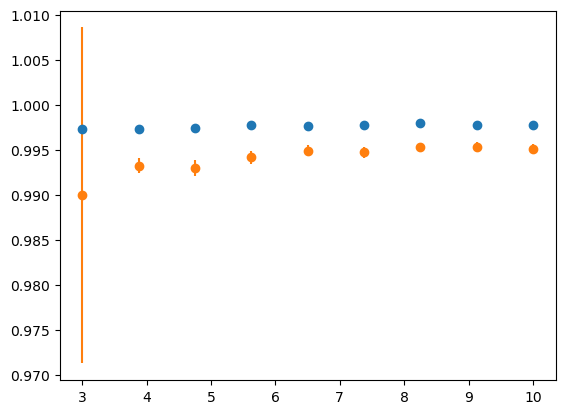

In [37]:
fig, ax = plt.subplots()


#plt.plot(t_size,R2.mean(axis=1).detach().numpy())
plt.errorbar(f,R2_test.mean(axis=[1,2])[:,0].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:,0].detach().numpy())
plt.errorbar(f,R2_test.mean(axis=[1,2])[:,1].detach().numpy(),fmt='o',yerr=R2_test.std(axis=[1,2])[:,1].detach().numpy())
